# 물체 감지(SSD)
### ssd 절차
1. 300*300 resize
2. default box 여러개 생성
3. 전처리한 이미지를 SSD network에 입력
4. 신뢰도 높은 default box를 top_k개 추출. label은 가장 높은 신뢰도
5. 오프셋 정보를 사용하여 default box를 bounding box로 변형
6. 최종 bounding box와 label 출력

In [3]:
from math import sqrt
from itertools import product
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import random
import time
import xml.etree.ElementTree as ET
import cv2
%matplotlib inline

In [4]:
#utils folder에 있는 data agumentation.py에서 import 
from pytorch_advanced.objectdetection.utils.data_augumentation import *
from pytorch_advanced.objectdetection.utils.match import *

In [5]:
rootpath = './pytorch_advanced/objectdetection/data/VOCdevkit/VOC2012/'

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
              'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
              'sheep','sofa','train','tvmonitor']

# SSD 300 설정

ssd_cfg = {
    'num_classes' : 21,
    'input_size' : 300,
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4], # 출력할 DBox 화면비 종류
    'feature_maps' : [38, 19, 10, 5, 3, 1], # 각 source의 화상 크기
    'steps' : [8, 16, 32, 64, 100, 300], # DBox 크기 결정
    'min_sizes' : [30, 60, 111, 162, 213, 264], # DBox 크기 결정
    'max_sizes' : [60, 111, 162, 213, 264, 315], # DBox 크기 결정
    'aspect_ratios' : [[2], [2,3], [2,3], [2,3], [2], [2]],
}

### make_datapath_list
- 학습 및 검증용 화상 데이터, 어노테이션 데이터의 파일 경로 리스트 작성

In [6]:
# 학습 및 검증용 화상 데이터, 어노테이션 데이터의 파일 경로 리스트 작성

def make_datapath_list(rootpath):
    """
    데이터 경로를 저장한 리스트 작성
    Parameters
    ----------
    rootpath : str
        데이터 폴더의 경로
    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로 저장 리스트
    """

    # 화상 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 훈련 및 검증 파일 ID 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 훈련 데이터의 화상파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백 및 줄바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄바꿈 제거
        img_path = (imgpath_template % file_id) # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [7]:
# 파일 경로 리스트 작성
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# 동작 확인
# print(train_img_list)

### Anno_xml2list
- XML 형식의 어노테이션을 리스트 형식으로 변환하는 클래스

In [8]:
# XML 형식의 어노테이션을 리스트 형식으로 변환하는 클래스


class Anno_xml2list(object):
    """
    한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
    
    Attributes
    ----------
    classes : 리스트
        VOC의 클래스명을 저장한 클래스
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환
        Parameters
        ----------
        xml_path : str
            xml 파일 경로
        width : int
            대상 화상 폭
        height : int
            대상 화상 높이
        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만큼의 요소를 가짐.
        """

        # 화상 내 모든 물체의 어노테이션을 이 리스트에 저장
        ret = []

        # XML 파일 로드
        xml = ET.parse(xml_path).getroot()

        # 화상 내 물체의 수 만큼 반복
        for obj in xml.iter('object'):

            # annotation에서 검지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 물체 이름
            bbox = obj.find('bndbox')  # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고, 0 ~ 1로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC는 원점이 (1, 1)이므로 1을 빼서 (0, 0)으로 한다.
                cur_pixel = int(bbox.find(pt).text) - 1

                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':  # x 방향의 경우 폭으로 나눔.
                    cur_pixel /= width
                else:  # y방향의 경우 높이로 나눔.
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # res에 [xmin, ymin, xmax, ymax, label_ind]를 더한다.
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

In [9]:
# 동작 확인
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
              'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
              'sheep','sofa','train','tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용으로 Opencv 사용
ind = 1
img_file_path = val_img_list[ind]
img = cv2.imread(img_file_path) # [높이][폭][색BGR]
height, width, channels = img.shape # 화상 크기 취득

# 어노테이션을 리스트로 표시
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

### DataTransform
- 화상과 어노테이션 전처리를 실시하는 클래스

In [10]:
# 입력 영상의 전처리 클래스

class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동.
    화상 크기를 300*300으로 한다.
    학습 시 데이터 확장을 수행.
    Attributes
    ----------
    input_size : int
        리사이즈 대상 화상의 크기
    color_mean : (B, G, R)
        각 색상채널 평균 값
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                ToAbsoluteCoords(),  # 어노테이션 데이터의 규격화 반환
                PhotometricDistort(),  # 화상의 색조 등 임의 변화
                Expand(color_mean),  # 화상 캔버스 확대
                RandomSampleCrop(),  # 화상 내 특정 부분 무작위 추출
                RandomMirror(),  # 화상 반전
                ToPercentCoords(),  # 어노테이션 데이터를 0 ~ 1로 규격화
                Resize(input_size),  # 화상 크기를 input_size*input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상 평균값 빼기
            ]),
            'val': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                Resize(input_size),  # 화상 크기를 input_size * input_size로 변환
                SubtractMeans(color_mean)  # BGR 색상 평균값 빼기
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        """
        return self.data_transform[phase](img, boxes, labels)

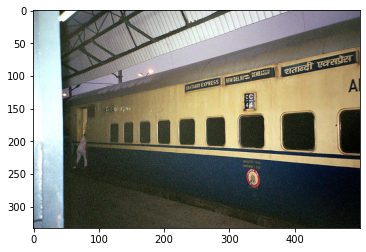

C:\Users\PC\Desktop\python\self_study\pyTorch\pytorch_advanced\objectdetection\utils\data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


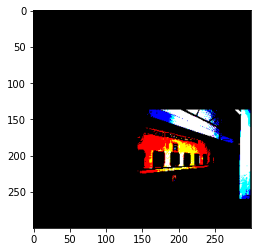

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


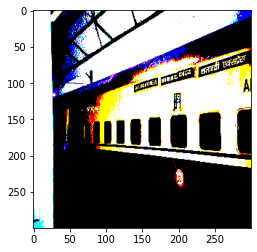

In [11]:
# 동작 확인

# 1. 화상 읽기
image_file_path = train_img_list[0]
img = cv2.imread(img_file_path) # [높이][폭][색BGR]
height, width, channels = img.shape # 화상 크기 취득

# 2. 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원본 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104, 117 ,123) # (bgr) 색상의 평균값
input_size = 300
transform = DataTransform(input_size, color_mean)

# 5. Train 화상 표시
phase = 'train'
img_transformed, boxes, labels = transform(
                                    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

# 6. Val 화상 표시
phase = 'val'
img_transformed, boxes, labels = transform(
                                    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


### VOCDataset
- 데이터셋 작성

In [12]:
# VOC2012의 dataset 작성

class VOCDataset(data.Dataset):
    """
    VOC2012의 데이터셋을 작성하는 클래스. 파이토치의 dataset 클래스를 상속
    ----------
    img_list : 리스트
        화상 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train 또는 val 지정
        self.transform = transform  # 화상 변형
        self.transform_anno = transform_anno  # 어노테이션 데이터를 xml에서 리스트로 변경

    def __len__(self):
        '''화상의 매수 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션 취득
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''전처리한 화상의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭 취득'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
        height, width, channels = img.shape  # 화상 크기 취득

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 색상 채널으 ㅣ순서가 BGR이므로 RGB로 순서 변경
        # (높이, 폭, 색상 채널)의 순서를 (색상 채널, 높이, 폭)으로 변경
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBox와 라벨을 세트로 한 np.array 작성. 변수 이름 gt는 ground truth의 의미
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [13]:
# 동작 확인
color_mean = (104, 117, 123) # BGR 평균값
input_size = 300 # 화상의 input 사이즈를 300*300으로 함.

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train',
                transform=DataTransform(input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='train',
                transform=DataTransform(input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

# 데이터 출력 예
val_dataset.__getitem__(1)

(tensor([[[158.7906, 166.7748, 156.7755,  ...,   0.0000,   0.0000,   0.0000],
          [164.9799, 158.0656, 130.2673,  ...,   0.0000,   0.0000,   0.0000],
          [146.6171, 120.4542,  84.1581,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [-75.5733, -68.0809, -72.2774,  ...,   0.0000,   0.0000,   0.0000],
          [-81.6184, -77.5859, -76.4424,  ...,   0.0000,   0.0000,   0.0000],
          [-87.3841, -81.6007, -74.0952,  ...,   0.0000,   0.0000,   0.0000]],
 
         [[146.0404, 153.0360, 142.3207,  ...,   0.0000,   0.0000,   0.0000],
          [152.2296, 144.8854, 118.6376,  ...,   0.0000,   0.0000,   0.0000],
          [132.4606, 107.3853,  74.7190,  ...,   0.0000,   0.0000,   0.0000],
          ...,
          [-43.1693, -37.8190, -44.2886,  ...,   0.0000,   0.0000,   0.0000],
          [-46.4547, -45.1697, -46.5785,  ...,   0.0000,   0.0000,   0.0000],
          [-52.4065, -49.5891, -44.2313,  ...,   0.0000,   0.0000,   0.0000]],
 
         [[164.1541, 174.115

### od_collate_fn
- 데이터 로더 구현

In [14]:
def od_collate_fn(batch):
    """
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다르다.
    화상 내의 물체 수가 두개이면 (2, 5)사이즈이지만, 세 개이면 (3, 5) 등으로 바뀐다.
    변화에 대응하는 DataLoader를 만드는 collate_fn을 작성한다.
    collate_fn은 파이토치 리스트로 mini batch를 작성하는 함수이디ㅏ.
    미니 배치 분량 화상이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는 
    차원을 가장 앞에 하나 추가하여 리스트 형태를 변형한다.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]은 화상 gt
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]은 어노테이션 gt

    # imgs는 미니배치 크기으 ㅣ리스트
    # 리스트 요소는 torch.Size([3, 300, 300])
    # 이 리스트를 torch.Size([batch_num, 3, 300, 300])의 텐서로 변환
    imgs = torch.stack(imgs, dim=0)

    # targets은 어노테이션의 정답인 gt 리스트
    # 리스트 크기 = 미니 배치 크기
    # targets 리스트의 요소는 [n, 5] 
    # n은 화상마다 다르며 화상 속 물체의 수
    # 5는 [xmin, ymin, xmax, ymax, class_index]

    return imgs, targets

In [15]:
# 데이터 로더 작성
batch_size = 4

train_dataloader = data.DataLoader(
                        train_dataset, batch_size =batch_size, shuffle=True, collate_fn=od_collate_fn)


val_dataloader = data.DataLoader(
                        val_dataset, batch_size =batch_size, shuffle=True, collate_fn=od_collate_fn)

# 사전형 변수에 정리
dataloaders_dict = {'train' : train_dataloader,
                    'val' : val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict['val']) # 반복자로 변환
images, targets = next(batch_iterator) # 첫번째 요소 추출
print(images.size()) # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size()) # 미니 배치 크기 리스트, 각 요소는 [n, 5] , n은 물체 수

torch.Size([4, 3, 300, 300])
4
torch.Size([1, 5])


### make_vgg
- vgg 모듈 작성

In [16]:
# 34층에 걸친 vgg 모듈을 작성

def make_vgg():
    layers = []
    in_channels = 3  # 색 채널 수

    # vgg 모듈에서 사용하는 합성곱 층이나 최대 풀링 채널 수 
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceil은 계산 결과(float)에서 출력 크기의 소수점을 올려 정수로 하는 모드
            # default는 계산 결과(float)에서 출력 크기의 소수점을 버려 정수로 하는 floor 모드
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # ReLU 인수 inplace는 ReLU에 대한 입력을 메모리 상에 유지할 것인지, 혹은
            # 입력을 재작성 하여 출력으로 바꾼 후 메모리상에 유지하지 않을 것인지를 나타냄.
            # inplace=True 입력 시 메모리상에 입력을 유지하지 않고, 입력을 재작성 (메모리 절약됨)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

In [17]:
# 동작 확인
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

### make_extras
- extra 모듈 구현

In [18]:
# 8층에 걸친 extras 모듈ㅇ르 작성

def make_extras():
    layers = []
    in_channels = 1024  # vgg모듈에서 출력된 extra에 입력되는 화상 채널 수 

    # extra 모듈의 합성곱 층 채널 수를 설정하는 구성(configuration)
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]

    
# 활성화 함수의 ReLU는 SSD 모듈의 순전파에서 준비하고, 
# extra에서는 준비하지 않음.
    
    return nn.ModuleList(layers)

In [19]:
# 동작 확인
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


### make_loc_conf
- loc 및 conf 모듈 구현

In [20]:
# 디폴트 박스의 오프셋을 출력하는 loc_layers와
# 디폴트 박스 각 클래스 신뢰도 confidence를 출력하는 conf_layers 작성

def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGG의 22층, conv4_3(source1)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    # VGG의 최종층(source2)의 합성곱 층
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source3)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    # extra（source4)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    # extra（source5）의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    # extra（source6）의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

In [21]:
# 동작 확인
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### L2Norm
- conv4_3에서 출력에 적용하는 L2Norm층을 구현

In [22]:
# convC4_3의 출력을 scale=20의 L2Norm으로 정규화하는 층

class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  #  부모 클래스의 생성자 실행
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 계수 weight의 초깃값으로 설정할 값
        self.reset_parameters()  # 파라미터 초기화
        self.eps = 1e-10

    def reset_parameters(self):
        '''결합 파라미터의 scale 크기 값으로 초기화를 실행'''
        init.constant_(self.weight, self.scale)  # weight 값이 모두 scale(=20)이 된다.

    def forward(self, x):
        '''38*38의 특징량에 대해 512 채널에 걸쳐 제곱합의 루트를 구했다.
        38*38개의 값을 사용하여 각 특징량을 정규화한 후 계수를 곱하여 계산하는 층'''

        # 각 채널의 38*38개 특징량의 채널 방향 제곱합을 계산하고
        # 루트를 구해 나누어 정규화한다.
        # norm의 텐서 사이즈는 torch.Size([batch_num, 1, 38, 38])
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 계수를 곱한다. 계수는 채널마다 하나로, 512개의 계수를 갖는다.
        # self.weight의 텐서 사이즈는 torch.Size([512])로,
        # torch.Size([batch_num, 512, 38, 38])까지 변형한다.
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

### DBox
- 디폴트 박스 구현

In [23]:
# 디폴트 박스를 출력하는 클래스


class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 초기 설정
        self.image_size = cfg['input_size']  # 화상 크기는 300
        # [38, 19, …] 각 source의 특징량 맵 크기
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # source 개수 = 6
        self.steps = cfg['steps']  # [8, 16, …] DBox의 픽셀 크기

        self.min_sizes = cfg['min_sizes']
        # [30, 60, …] 작은 정사각형의 DBox 픽셀 크기(정확히는 면적)

        self.max_sizes = cfg['max_sizes']
        # [60, 111, …] 큰 정사각형의 DBox 픽셀 크기(정확히는 면적)

        self.aspect_ratios = cfg['aspect_ratios']  # 정사각형의 DBox 화면비(종횡비)

    def make_dbox_list(self):
        '''DBox 작성'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # f 까지의 수로 두 쌍의 조합을 작성. f_p_2개
                
                # 특징량의 화상 크기
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBox의 중심 좌표 x,y. 0~1 로 정규화되어 있다.
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # 화면비 1의 작은 DBox [cx,cy, width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # 화면비 1의 큰 DBox [cx,cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # 그 오 ㅣ화면비의 defBox [cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k*sqrt(ar), s_k*sqrt(ar)]

        # DBox를 텐서로 변환 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBox가 화상 밖으로 돌출되는 것을 막기 위해 크기를 최소 0, 최대 1로 한다.
        output.clamp_(max=1, min=0)

        return output

In [24]:
# 동작 확인

# DBox 작성
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# dbox 출력 확인 
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.141421,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,1.000000,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


### SSD 
- 순전파 계산을 실행하여 ssd 클래스 구현

In [25]:
# SSD클래스 작성


class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference
        self.num_classes = cfg["num_classes"]  # 클래스 수=21

        # SSD 네트워크 작성
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론 시 Detect 클래스 준비
        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list()  # loc와 conf에 입력 source1 ~ 6 저장
        loc = list()  # loc의 출력 저장
        conf = list()  # conf의 출력 저장

        # vgg의 conv4_3까지 계산
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3의 출력을 L2Norm에 입력하고, source1을 작성하여 sources에 추가
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vgg를 마지막까지 계산하여 source2를 작성하고 sources에 추가
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extras의 conv와 ReLU 계산
        # source3～6을 sources에 추가
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLU를 하여 source에 넣는다.
                sources.append(x)

        # source1 ~ 6 에 각각 대응하는 합성곱을 1회씩 적용
        # zip으로 for 루프의 여러 리스트 요소 취득
        # source1 ~ 6 까지 있어 루프가 6회 실시
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permute로 요소의 순서를 교체
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x), c(x)로 합성곱 실행
            # l(x), c(x)으 ㅣ출력 크기는 [batch_num, 4*화면비의 종류 수 , featuremap높이, featuremap폭]
            # source에 따라 화면비으 ㅣ종류 수가 다르며, 번거로워 순서를 바꾸어서 조정
            # permute로 요소 순서를 당므과 같이 교체 
            # [minibatch 수 , featuremap 수 , featuremap 수 ,4*화면비의 종류 수]
            # torch.contiguous()은 메모리 상에 연속적으로 요소를 배치하는 명령
            # 이후 view 함수 사용
            # view를 수행하므로 대상의 변수가 메모리 상에 연속적으로 배치되어야 한다.

        # loc와 conf의 모양 변형
        # loc의 크기는 torch.Size([batch_num, 34928])
        # conf의 크기는 torch.Size([batch_num, 183372])가 된다.
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # loc와 conf의 모양 조정
        # lloc의 크기는 torch.Size([batch_num, 8732, 4])
        # conf의 크기는 torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 마지막으로 출력
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  #  추론 시
            # detect 클래스의 forward 실행
            # 반환 값의 크기는 torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 학습 시
            return output
            # 반환 값은 (loc, conf, dbox_list)의 튜플

### Decode
- decode 함수 구현

In [26]:
# 오프셋 정보로  DBox를 BBox로 변환하는 함수

def decode(loc, dbox_list):
    """
    오프셋 정보로  DBox를 BBox로 변환한다.
    Parameters
    ----------
    loc:  [8732,4]
        SSD 모델로 추론하는 오프셋 정보
    dbox_list: [8732,4]
        DBox 정보
    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBox 정보
    """

    # DBox는 [cx, cy, width, height]로 저장되었다.
    # loc도 [Δcx, Δcy, Δwidth, Δheight]로 저장되었다.

    # 오프셋 정보로 BBox를 구한다.
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxes의 크기는 torch.Size([8732, 4])가 된다.

    # BBox의 좌표 정보를 [cx, cy, width, height]에서 [xmin, ymin, xmax, ymax] 로 변경
    boxes[:, :2] -= boxes[:, 2:] / 2  # 좌표 (xmin,ymin)로 변환
    boxes[:, 2:] += boxes[:, :2]  # 좌표 (xmax,ymax)로 변환

    return boxes

### nm_suppression
- `Non-maximum Suppression` 실시 함수 구현
- 미리 8,732개의 DBox를 준비하여 물체를 감지하므로, BBox를 계산하면 화상 속 동일한 물체에 다른 BBox가 조금 다르게 복수 피팅 될 때가 있다. 겹치는 BBox를 삭제하고 하나의 물체에 하나의 BBox만 남기는 처리를 Non-Maximum Suppression이라고 한다.

In [27]:
# Non-Maximum Suppression을 실시하는 함수


def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppression을 실시하는 함수
    boxes중 겹치는（overlap이상) BBox 삭제
    Parameters
    ----------
    boxes : [신뢰도 임곗값（0.01)을 넘은 BBox 수,4]
        BBox 정보
    scores :[신뢰도 임곗값（0.01)을 넘은 BBox 수]
        conf 정보
    Returns
    -------
    keep : 리스트
        conf의 내림차순으로 nms를 통과한 index를 저장
    count：int
        nms를 통과한 BBox 수
    """

    # return 모형 작성
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep：torch.Size([신뢰도 임곗값을 넘은 BBox 수)], 요소는 전부 0

    # 각 BBox의 면적 area 계산
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxes 복사. 나중에 BBox 중복도(IOU) 계산 시 모형으로 준비
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # scores를 오름차순으로 나열
    v, idx = scores.sort(0)

    # 상위 top_k개(200개)의 BBox index를 꺼낸다(200개가 존재하지 않는 경우도 있음)
    idx = idx[-top_k:]

    # idx의 요소 수가 0이 아닌 한 루프한다.
    while idx.numel() > 0:
        i = idx[-1]  # conf의 최대 index를 i로 지정

        # keep의 끝에 conf 최대 index 저장
        # 이 index의 BBox와 크게 겹치는 BBox를 삭제
        keep[count] = i
        count += 1

        # 마지막 BBox는 루프를 빠져나옴
        if idx.size(0) == 1:
            break

        # 현재 conf 최대의 index를 keep에 저장했으므로 idx를 하나 감소시킴
        idx = idx[:-1]

        # -------------------
        # 지금부터 keep에 저장한 BBox와 크게 겹치는 BBox를 추출하여 삭제
        # -------------------
        # 하나 감소시킨 idx까지의 BBox를 out으로 지정한 변수로 작성
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # 모든 BBox를 현재 BBox=index가 i로 겹치는 값까지로 설정(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # w와 h의 텐서 크기를 index 하나 줄인 것으로 한다.
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clamp한 상태에서 BBox의 폭과 높이를 구한다.
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 폭이나 높이가 음수인 것은 0으로 한다.
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clamp된 상태 면적을 구한다.
        inter = tmp_w*tmp_h

        # IoU = intersect 부분 / (area(a) + area(b) - intersect 부분) 계산
        rem_areas = torch.index_select(area, 0, idx)  # 각 BBox의 원래 면적
        union = (rem_areas - inter) + area[i]  # 두 구역의 합(OR) 면적
        IoU = inter/union

        # IoU가 overlap보다 작은 idx만 남긴다
        idx = idx[IoU.le(overlap)]  # le은 Less than or Equal to 처리를 하는 연산
        # IoU가 overlap보다 큰 idx는 처음 선택한 keep에 저장한 idx와 동일한 물체에 BBox를 둘러싸고 있어 삭제
    
    # while 루프에서 빠져나오면 종료

    return keep, count

### Detect
- detect 클래스 구현

In [28]:
# SSD 추론 시 conf와 loc의 출력에서 중복을 제거한 BBox 출력


class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  # conf를 소프트맥스 함수로 정규화하기 위해 준비
        self.conf_thresh = conf_thresh  # conf가 conf_thresh=0.01보다 높은 DBox만 취급
        self.top_k = top_k  # conf가 높은 top_k개를 nm_supression으로 계산에 사용하는 top_k = 200
        self.nms_thresh = nms_thresh  # nm_supression으로 IOU가 nms_thresh=0.45보다 크면 동일한 물체의 BBox로 간주

    def forward(self, loc_data, conf_data, dbox_list):
        """
        순전파 계산 실행
        
        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            오프셋 정보
        conf_data: [batch_num, 8732,num_classes]
            감지 신뢰도
        dbox_list: [8732,4]
            DBox 정보
        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num, 클래스, conf의 top200, BBox 정보）
        """

        # 각 크기 취득
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox의 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # conf는 소프트맥스를 적용하여 정규화
        conf_data = self.softmax(conf_data)

        # 출력 형식을 작성. 텐서 크기 [minibatch 수, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_data 순서를 [batch_num,8732,num_classes]에서 [batch_num, num_classes,8732]로 변경
        conf_preds = conf_data.transpose(2, 1)

        # 미니 배치마다 루프
        for i in range(num_batch):

            # 1. loc와 DBox로 수정한 BBox [xmin, ymin, xmax, ymax] 를 구한다
            decoded_boxes = decode(loc_data[i], dbox_list)

            # conf의 복사본 작성
            conf_scores = conf_preds[i].clone()

            # 화상 클래스별 루프(배경 클래스의 index인 0은 계산하지 않고 index=1부터）
            for cl in range(1, num_classes):

                # 2.conf의 임곗값을 넘은 BBox를 꺼낸다.
                # conf의 임곗값을 넘고 있는지 마스크를 작성하여
                # 임곗값을 넘은 conf의 인덱스를 c_mask로 취득
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gt는 Greater than을 의미. gt로 임곗값이 넘으면 1, 이하는 0
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scores는 torch.Size([임곗값을 넘은 BBox 수])
                scores = conf_scores[cl][c_mask]

                # 임곗값을 넘은 conf가 없는 경우, scores=[]는 아무것도 하지 않음.
                if scores.nelement() == 0:  # nelement로 요소 수의 합계를 구함
                    continue

                # c_mask를 decoded_boxes에 적용할 수 있도록 크기 변경
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_mask를 decoded_boxes로 적용
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]로 1차원이 되기 때문에
                # view에서 (임곗값을 넘은 BBox 수, 4) 크기로 바꿈

                # 3. Non-Maximum Suppression을 실시하여 중복되는 BBox 제거
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids：conf의 내림차순으로 Non-Maximum Suppression을 통과한 index 작성
                # count：Non-Maximum Suppression를 통과한 BBox 수

                # output에 Non-Maximum Suppression를 뺀 결과 저장
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])

### MultiBoxLoss
- SSD의 손실함수 클래스 

In [29]:
class MultiBoxLoss(nn.Module):
    """SSD의 손실함수 클래스 """

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 match 함수의 jaccard 계수의 임계치
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Mining의 음과 양 비율
        self.device = device  # 계산 device(CPU | GPU)

    def forward(self, predictions, targets):
        """
        손실함수 계산
        Parameters
        ----------
        predictions : SSD net의 훈련 시 출력 (tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。
        targets : [num_batch, num_objs, 5]
            5는 정답인 어노테이션 정보[xmin, ymin, xmax, ymax, label_ind]
        Returns
        -------
        loss_l : 텐서
            loc의 손실 값
        loss_c : 텐서
            conf의 손실 값
        """

        # SSD의 출력이 튜플로 되어 있어 개별적으로 분리함
        loc_data, conf_data, dbox_list = predictions

        # 요소 수를 파악
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox의 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수= 21

        # 손실 계산에 사용할 것을 저장하는 변수 작성
        # conf_t_label：각 DBox에 가장 가까운 정답 BBox의 라벨을 저장 
        # loc_t: 각 DBox에 가장 가까운 정답 BBox의 위치 정보 저장 
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_t와 conf_t_label에 
        # DBox와 정답 어노테이션 targets를 amtch한 결과 덮어쓰기
        for idx in range(num_batch):  # 미니 배치 루프

            # 현재 미니 배치의 정답 어노테이션 BBox와 라벨 취득
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # 라벨 [물체1 라벨, 물체2 라벨, ...]
            labels = targets[idx][:, -1].to(self.device)

            # 디폴트 박스를 새로운 변수로 준비
            dbox = dbox_list.to(self.device)

            # match 함수를 실행하여 loc_t와 conf_t_label 내용 갱신
            # loc_t: 각 DBox에 가장 가까운 정답 BBox 위치 정보가 덮어써짐.
            # conf_t_label：각 DBox에 가장 가까운 정답 BBox 라벨이 덮어써짐.
            # 단, 가장 가까운 BBox와 jaccard overlap이 0.5보다 작은 경우,
            # 정답 BBox의 라벨 conf_t_label은 배경 클래스 0으로 한다.
            variance = [0.1, 0.2]
            # 이 variance는 DBox에서 BBox로 보정 계산할 때 사용하는 식의 계수
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 위치 손실 : loss_l을 계산
        # Smooth L1 함수로 손실 계산. 단, 물체를 발견한 DBox의 오프셋만 계산
        # ----------
        # 물체를 감지한 BBox를 꺼내는 마스크 작성
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_mask를 loc_data 크기로 변형
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBox의 loc_data와 지도 데이터 loc_t 취득
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 물체를 발견한 Positive DBox의 오프셋 정보 loc_t의 손실(오차)를 계산
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # 클래스 예측의 손실 : loss_c를 계산
        # 교차 엔트로피 오차 함수로 손실 계산. 단 배경 클래스가 정답인 DBox가 압도적으로 많으므로,
        # Hard Negative Mining을 실시하여 물체 발견 DBox 및 배경 클래스 DBox의 비율이 1:3이 되도록 한다.
        # 배경 클래스 DBox로 예상한 것 중 손실이 적은 것은 클래스 예측 손실에서 제외
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # 클래스 예측의 손실함수 계산(reduction='none'으로 하여 합을 취하지 않고 차원 보존)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # Negative DBox중 Hard Negative Mining으로 추출하는 것을 구하는 마스크 작성
        # -----------------

        # 물체를 발견한 Positive DBox의 손실을 0으로 한다.
        # (주의) 물체는 label이 1 이상, 라벨 0은 배경을 의미
        num_pos = pos_mask.long().sum(1, keepdim=True)  # 미니 배치별 물체 클래스 예측 수
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 물체를 발견한 DBox는 손실 0으로 한다.

        # Hard Negative Mining
        # 각 DBox 손실의 크기 loss_c 순위 idx_rank를 구함
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        #  (주의) 구현된 코드는 특수하며 직관적이지 않음.
        # 위 두 줄의 요점은 각 DBox에 대해 손실 크기가 몇 번째인지의 정보를 
        # idx_rank 변수로 빠르게 얻는 코드이다.
        
        # DBox의 손실 값이 큰 쪽부터 내림차순으로 정렬하여 DBox의 내림차순의 index를 loss_idx에 저장한다.
        # 손실 크기 loss_c의 순위 idx_rank를 구한다.
        # 내림차순이 된 배열 index인 loss_idx를 0부터 8732까지 오름차순으로 다시 정렬하기 위하여
        # 몇 번째 loss_idx의 인덱스를 취할 지 나타내는 것이 idx_rank이다.
        # 예를 들면 idx_rank 요소의 0번째 = idx_rank[0]을 구하는 것은 loss_idx의 값이 0인 요소,
        # 즉 loss_idx[?] =0은 원래 loss_c의 요소 0번째는 내림차순으로 정렬된 loss_idx의 몇 번째입니까?를 
        # 구하는 것이 되어 결과적으로, ? = idx_rank[0]은 loss_c의 요소 0번째가 
        # 내림차순으로 몇 번째인지 나타낸다.

        # 배경 DBox의 수 num_neg를 구한다. HardNegative Mining으로 
        # 물체 발견 DBox으 ㅣ수 num_pos의 세 배 (self.negpos_ratio 배)로 한다.
        # DBox의 수를 초과한 경우에는 DBox의 수를 상한으로 한다.
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rank에 각 DBox의 손실 크기가 위에서부터 몇 번째인지 저장되었다.
        # 배경 DBox의 수 num_neg보다 순위가 낮은(손실이 큰) DBox를 취하는 마스크 작성
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # (종료) 지금부터 Negative DBox 중 Hard Negative Mining으로 추출할 것을 구하는 마스크를 작성
        # -----------------

        # 마스크 모양을 고쳐 conf_data에 맞춘다
        # pos_idx_mask는 Positive DBox의 conf를 꺼내는 마스크이다.
        # neg_idx_mask는 Hard Negative Mining으로 추출한 Negative DBox의 conf를 꺼내는 마스크이다.
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_data에서 pos와 neg만 꺼내서 conf_hnm으로 한다. 형태는 torch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # gt는 gtは greater than (>)의 약칭. mask가 1인 index를 꺼낸다
        # pos_idx_mask+neg_idx_mask는 덧셈이지만 index로 mask를 정리할 뿐임.
        # pos이든 neg이든 마스크가 1인 것을 더해 하나의 리스트로 만들어 이를 gt로 췯그한다.

        # 마찬가지로 지도 데이터인 conf_t_label에서 pos와 neg만 꺼내, conf_t_label_hnm 으로 
        # torch.Size([pos+neg]) 형태가 된다
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidence의 손실함수 계산(요소의 합계=sum을 구함)
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 물체를 발견한 BBox의 수 N (전체 미니 배치의 합계) 으로 손실을 나눈다.
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

## 1. 데이터셋 구현
---

In [30]:
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

# Dataset 작성
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
              'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
              'sheep','sofa','train','tvmonitor']

color_mean = (104, 117, 123) # BGR 색 평균 값 

input_size = 300 # input 크기를 300*300 으로 설정

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', transform=DataTransform(
                            input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val', transform=DataTransform(
                            input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

# dataloader 작성
batch_size=32

train_dataloader = data.DataLoader(
                            train_dataset, batch_size=batch_size, shuffle=True, collate_fn = od_collate_fn)

val_dataloader = data.DataLoader(
                            val_dataset, batch_size = batch_size, shuffle=False, collate_fn= od_collate_fn)

# 사전 오브젝트로 정리
dataloaders_dict = {'train' : train_dataloader, 'val' : val_dataloader}

## 2. 신경망 구현
---

In [31]:
# SSD300 설정
ssd_cfg = {
    'num_classes' : 21,
    'input_size' : 300,
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4],  # 출력할 DBox의 화면 비 종류
    'feature_maps' : [38, 19, 10, 5, 3, 1],  # 각 source 화상 크기
    'steps' : [8, 16, 32, 64, 100, 300],
    'min_sizes' : [30, 60, 111, 162, 213, 264] , # DBox 크기(최소)
    'max_sizes' : [60, 111, 162, 213, 264, 315], # DBox 크기(최대)
    'aspect_ratios' : [[2], [2,3], [2,3], [2,3], [2], [2]]
}

# SSD 네트워크 모델
net = SSD(phase='train', cfg=ssd_cfg)

# SSD 초기 가중치 설정
# ssd의 vgg에 가중치 로드
vgg_weights = torch.load('./pytorch_advanced/objectdetection/weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssd의 기타 네트워크 가중치는 He의 초기치로 초기화

def weights_init(m) :
    if isinstance(m, nn.Conv2d) :
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None : # bias 항이 있는 경우
            nn.init.constant_(m.bias, 0.0)
            
# He의 초기치 적용
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPU를 사용할 수 있는지 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'사용 중인 장치 : {device}')

print('네트워크 설정 완료 : 학습된 가중치를 로드했습니다.')

사용 중인 장치 : cpu
네트워크 설정 완료 : 학습된 가중치를 로드했습니다.


## 3. 손실함수 구현
---

In [32]:
# 손실함수 설정
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 최적화 기법 선정
optimizer = optim.SGD(net.parameters(), lr=1e-3, 
                             momentum = 0.9, weight_decay=5e-4)

# 학습 및 검증 실시
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs) :
    
    # GPU 사용 확인
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f'사용 중인 장치 : {device}')
    
    # 네트워크를 gpu로
    net.to(device)
    
    # 네트워크가 어느정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True
    
    # 반복자 카운터 설정
    iteration = 1
    epoch_train_loss = 0.0 # 에포크 손실 합
    epoch_val_loss = 0.0 # 에포크 손실 합
    logs = []
    
    
    # 에폭 루프
    for epoch in range(num_epochs+1) :
        
        # 시작 시간 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()
        
        print('-' * 20)
        print(f'Epoch : {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        # 에폭 별 훈련 및 검증 루프
        for phase in ['train', 'val'] :
            if phase == 'train' :
                net.train() # 모델을 훈련 모드로
                print('(train)')
            else :
                if ((epoch+1) % 10  == 0 ) :
                    net.eval() # 모델을 검증 모드로
                    print('-' * 20)
                    print('(val)')
                else :
                    # 검증은 10 회 중 1회만 실시
                    continue
                    
            # 데이터 로더에서 미니 배치씩 꺼내 루프
            for images, targets in dataloaders_dict[phase] :
                # GPU를 사용할 수 있으면 GPU에 데이터를 보낸다.
                images = images.to(device)
                # 리스트 각 요소의 텐서를 GPUㄹ
                targets = [ann.to(device) for ann in targets]
                # 옵티마이저 초기화
                optimizer.zero_grad()
                
                
                # 순전파 계산
                with torch.set_grad_enabled(phase=='train') :
                    # 순전파 계산
                    outputs = net(images)
                    loss_l, loss_c = criterion(outputs, targets) 
                    loss = loss_l + loss_c
                    
                    # 훈련 시에는 역전파
                    if phase == 'train' :
                        loss.backward() 
                        
                        # 경사가 너무 커지면 계산이 부정확해 clip에서 최대경사 2.0에 고정
                        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
                        
                        optimizer.step() # 파라미터 갱신
                        
                        if (iteration % 10 == 0) : # 10 iter에 한 번 손실 표시
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print(f'반복 {iteration} || Loss : {loss.item():.4f} || 10 iter : {duration:.4f} \
                                    sec.')

                            t_iter_start =time.time()
                            
                        epoch_train_loss += loss.item()
                        iteration += 1
                        
                    # 검증 시
                    else :
                        epoch_val_loss += loss.item()
                        
            
            # epoch의 phase당 손실과 정답률
            t_epoch_finish = time.time()
            print('-' * 20)
            print(f'epoch {epoch+1} || Epoch_Train_loss : {epoch_train_loss:.4f} || Epoch_val_loss : {epoch_val_loss:.4f}')
            
            print(f'timer : {t_epoch_finish - t_epoch_start:.4f} sec')
            
            # 로그 저장
            loc_epoch = {'epoch' : epoch + 1,
                        'train_loss' : epcoh_train_loss,
                        'val_loss' : epoch_val_loss}
            los.append(los_epoch)
            df = pd.DataFrame(logs)
            df.to_csv('log_output.csv')
            
            epoch_train_loss = 0.0 # 에폭 손실 합
            epoch_val_loss = 0.0 # 에폭 손실 합
            
            # 네트워크 저장
            if ((epoch + 1) % 10 == 0 ) :
                torch.save(net.start_dict(), 'pytorch_advanced/objectdetection/weights/ssd300_' + str(epoch+1) + '.pth')

                
# 학습 및 검증 실시
num_epochs = 50
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

사용 중인 장치 : cpu
--------------------
Epoch : 1/50
--------------------
(train)


C:\Users\PC\Desktop\python\self_study\pyTorch\pytorch_advanced\objectdetection\utils\data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)


RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:62] data. DefaultCPUAllocator: not enough memory: you tried to allocate %dGB. Buy new RAM!0


---

# 추론 실시

In [ ]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
              'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
              'sheep','sofa','train','tvmonitor']

# SSD 300 설정

ssd_cfg = {
    'num_classes' : 21,
    'input_size' : 300,
    'bbox_aspect_num' : [4, 6, 6, 6, 4, 4], # 출력할 DBox 화면비 종류
    'feature_maps' : [38, 19, 10, 5, 3, 1], # 각 source의 화상 크기
    'steps' : [8, 16, 32, 64, 100, 300], # DBox 크기 결정
    'min_sizes' : [30, 60, 111, 162, 213, 264], # DBox 크기 결정
    'max_sizes' : [60, 111, 162, 213, 264, 315], # DBox 크기 결정
    'aspect_ratios' : [[2], [2,3], [2,3], [2,3], [2], [2]],
}

# SSD 네트워크 모델
net = SSD(phase='inference', cfg=ssd_cfg)

# SSD의 학습된 가중치 설정
# net_weights = torch.load('./pytorch_advanced/objectdetection/weights/ssd300_50.pth',
#                         map_location={'cuda:0' : 'cpu'})

net_weights = torch.load('./pytorch_advanced/objectdetection/weights/ssd300_mAP_77.43_v2.pth',
                        map_location={'cuda:0' : 'cpu'})

net.load_state_dict(net_weights)

print('네트워크 설정 완료 : 학습 가중치를 로드했습니다.')

In [ ]:
# 1. 화상 읽기

image_file_path = './pytorch_advanced/objectdetection/data/cowboy-757575_640.jpg'
img = cv2.imread(image_file_path) # [높이][폭][색BGR]
height, width, channels = img.shape # 이미지 크기 취득

# 2. 원본 화상 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 전처리 클래스 작성
color_mean = (104, 117, 123) # BGR 색 평균값
input_size= 300 # 화상 크기를 300*300 으로 설정
transform = DataTransform(input_size, color_mean)

# 4. 전처리
phase = 'val'
img_transformed, boxes, labels = transform(img, phase, '', '' ) # 어노테이션은 없어 ""으로 설정
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSD로 예측
net.eval() # 네트워크를 추론 모드로

x = img.unsqueeze(0) # 미니 배치화 : torch.Size([1, 3, 300, 300])

detections = net(x)

print(detections.shape)
print(detections)

In [ ]:
class SSDPredictShow():
    """SSD에서의 예측과 이미지 표시를 한꺼번에 하는 클래스"""

    def __init__(self, eval_categories, net):
        self.eval_categories = eval_categories  # 클래스명
        self.net = net  # SSD 네트워크

        color_mean = (104, 117, 123)  # (BGR)색상의 평균치
        input_size = 300  # 사진의 input 크기를 300 × 300으로 한다.
        self.transform = DataTransform(input_size, color_mean)  # 전처리 클래스

    def show(self, image_file_path, data_confidence_level):
        """
        물체 검출의 예측 결과를 표시하는 함수.
        Parameters
        ----------
        image_file_path:  str
            이미지 파일 경로
        data_confidence_level: float
            예측으로 발견할 수 있는 확신도의 역치
        Returns
        -------
        없음. rgb_img에 물체검출결과가 더해진 화상이 나타난다.
        """
        rgb_img, predict_bbox, pre_dict_label_index, scores = self.ssd_predict(
            image_file_path, data_confidence_level)

        self.vis_bbox(rgb_img, bbox=predict_bbox, label_index=pre_dict_label_index,
                      scores=scores, label_names=self.eval_categories)

    def ssd_predict(self, image_file_path, data_confidence_level=0.5):
        """
        SSD에서 예측시키는 함수.
        Parameters
        ----------
        image_file_path:  strt
            이미지 파일 경로
        dataconfidence_level: float
            예측으로 발견할 수 있는 확신도의 역치
        Returns
        -------
        rgb_img, true_bbox, true_label_index, predict_bbox, pre_dict_label_index, scores
        """

        # rgb 이미지 데이터 가져오기
        img = cv2.imread(image_file_path)  # [높이] [폭] [색상BGR]
        height, width, channels = img.shape  # 이미지 크기 가져오기
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 화상 전처리
        phase = "val"
        img_transformed, boxes, labels = self.transform(
            img, phase, "", "")  # 어노테이션이 존재하지 않기 때문에 ""로 한다
        img = torch.from_numpy(
            img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # SSD로 예측
        self.net.eval()  # 네트워크를 추론 모드로
        x = img.unsqueeze(0)  # 미니 배치 화：torch.Size([1, 3, 300, 300])

        detections = self.net(x)
        # detections의 형태는 torch.Size (1, 21, 200, 5]) ※200은 top_k 의 값

        # confidence_level 이 기준 이상을 꺼냄
        predict_bbox = []
        pre_dict_label_index = []
        scores = []
        detections = detections.cpu().detach().numpy()

        # 조건 이상의 값을 추출
        find_index = np.where(detections[:, 0:, :, 0] >= data_confidence_level)
        detections = detections[find_index]
        for i in range(len(find_index[1])):  # 추출한 물체 수만큼 루프
            if (find_index[1][i]) > 0:  # 배경 클래스가 아닌 것
                sc = detections[i][0]  # 확신도
                bbox = detections[i][1:] * [width, height, width, height]
                # find_index는 미니뱃지 수, 클래스, top의 tuple
                lable_ind = find_index[1][i]-1
                ## (주석)
                # 배경반이 0이므로 1을 뺀다

                # 반환 값 리스트에 추가
                predict_bbox.append(bbox)
                pre_dict_label_index.append(lable_ind)
                scores.append(sc)

        return rgb_img, predict_bbox, pre_dict_label_index, scores

    def vis_bbox(self, rgb_img, bbox, label_index, scores, label_names):
        """
        물체 검출의 예측 결과를 화상으로 표시시키는 함수.
        Parameters
        ----------
        rgb_img: rgb이미지
        대상 이미지 데이터
        bbox : list
        물체의 비폭스 목록
        label _ index : list
        물체의 라벨에 대한 인덱스
        scores : list
        물체의 확신도
        label _ names : list
        라벨명의 배열
        Returns
        -------
        없음. rgb_img에 물체검출결과가 더해진 화상이 나타난다.
        """
        # 테두리의 색 설정
        num_classes = len(label_names)  # 클래스 수 (배경 제외)
        colors = plt.cm.hsv(np.linspace(0, 1, num_classes)).tolist()

        # 이미지 표시
        plt.figure(figsize=(10, 10))
        plt.imshow(rgb_img)
        currentAxis = plt.gca()

        # BBox의 루프
        for i, bb in enumerate(bbox):

            # 라벨 명
            label_name = label_names[label_index[i]]
            color = colors[label_index[i]]  # クラスごとに別の色の枠を与える

            # 테두리에 붙이는 라벨 // 예) person : 0.72
            if scores is not None:
                sc = scores[i]
                display_txt = '%s: %.2f' % (label_name, sc)
            else:
                display_txt = '%s: ans' % (label_name)

            # 테두리 좌표
            xy = (bb[0], bb[1])
            width = bb[2] - bb[0]
            height = bb[3] - bb[1]

            # 직사각형을 그림
            currentAxis.add_patch(plt.Rectangle(
                xy, width, height, fill=False, edgecolor=color, linewidth=2))

            # 직사각형 틀의 왼쪽 상단에 라벨을 그림
            currentAxis.text(xy[0], xy[1], display_txt, bbox={
                             'facecolor': color, 'alpha': 0.5})

In [ ]:
# 화상 예측

img_file_path = './pytorch_advanced/objectdetection/data/cowboy-757575_640.jpg'

# 예측 및 결과를 화상으로 그린다
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(img_file_path, data_confidence_level=0.6)